In [6]:
x = 0
print x
import unicodecsv 
from datetime import datetime as dt

def read_csv(filename):
    with open(filename, 'rb') as f:
        reader = unicodecsv.DictReader(f)
        return list(reader)

def parse_maybe_int(i):
    if i == '':
        return  None
    else:
        return int(i)

def parse_date(date):
    if date == '':
        return None
    else:
        return dt.strptime(date,'%Y-%m-%d')
    
    

enrollments = read_csv('enrollments.csv')
daily_engagement = read_csv('daily-engagement.csv')
project_submissions = read_csv('project-submissions.csv')

for enrollment in enrollments:
    enrollment['cancel_date'] = parse_date(enrollment['cancel_date'])
    enrollment['days_to_cancel'] = parse_maybe_int(enrollment['days_to_cancel'])
    enrollment['is_canceled'] = enrollment['is_canceled'] == 'True'
    enrollment['is_udacity'] = enrollment['is_udacity'] == 'True'
    enrollment['join_date'] = parse_date(enrollment['join_date'])
    
print enrollments[0]


for engagement_record in daily_engagement:
    engagement_record['lessons_completed'] = int(float(engagement_record['lessons_completed']))
    engagement_record['num_courses_visited'] = int(float(engagement_record['num_courses_visited']))
    engagement_record['projects_completed'] = int(float(engagement_record['projects_completed']))
    engagement_record['total_minutes_visited'] = float(engagement_record['total_minutes_visited'])
    engagement_record['utc_date'] = parse_date(engagement_record['utc_date'])

print daily_engagement[0]


for submission in project_submissions:
    submission['completion_date'] = parse_date(submission['completion_date'])
    submission['creation_date'] = parse_date(submission['creation_date'])

print project_submissions[0]

0


{u'status': u'canceled', u'is_udacity': True, u'is_canceled': True, u'join_date': datetime.datetime(2014, 11, 10, 0, 0), u'account_key': u'448', u'cancel_date': datetime.datetime(2015, 1, 14, 0, 0), u'days_to_cancel': 65}


{u'lessons_completed': 0, u'num_courses_visited': 1, u'total_minutes_visited': 11.6793745, u'projects_completed': 0, u'acct': u'0', u'utc_date': datetime.datetime(2015, 1, 9, 0, 0)}
{u'lesson_key': u'3176718735', u'processing_state': u'EVALUATED', u'account_key': u'256', u'assigned_rating': u'UNGRADED', u'completion_date': datetime.datetime(2015, 1, 16, 0, 0), u'creation_date': datetime.datetime(2015, 1, 14, 0, 0)}


In [6]:
#排除重复数据
x = x + 1
print x
def get_unique_students(data):
    unique_students = set()
    for data_point in data:
        unique_students.add(data_point['account_key'])
    return unique_students

for engagement_record in daily_engagement:
    engagement_record['account_key'] = engagement_record['acct']
    del [engagement_record['acct']]

print len(enrollments)
unique_enrolled_students = get_unique_students(enrollments)
print len(unique_enrolled_students)

print len(daily_engagement)
unique_engagement_students = get_unique_students(daily_engagement)
print len(unique_engagement_students)

print len(project_submissions)
unique_project_submitters = get_unique_students(project_submissions)
print len(unique_project_submitters)

1


1640
1302
136240
1237
3642
743


In [7]:
daily_engagement[0]['account_key']
len(daily_engagement)

136240

In [8]:
num_problem_students = 0
for engagement in enrollments:
    if engagement['account_key'] not in unique_engagement_students and \
                    enrollment['days_to_cancel'] != enrollment['join_date'] :
        num_problem_students = num_problem_students + 1
        # print enrollment

print num_problem_students

71


In [9]:
udacity_test_accounts = set()
for enrollment in enrollments:
    if enrollment['is_udacity'] == True:
        udacity_test_accounts.add(enrollment['account_key'])
        

def remove_udacity_accounts(data):
    new_data = []
    for data_point in data:
        if data_point['account_key'] not in udacity_test_accounts:
            new_data.append(data_point)
            
    return new_data

new_enrollments = remove_udacity_accounts(enrollments)
print len(enrollments)
print enrollments[20]
print len(new_enrollments)


new_daily_engagement = remove_udacity_accounts(daily_engagement)
print len(daily_engagement)
print len(new_daily_engagement)

new_project_submissions = remove_udacity_accounts(project_submissions)
print len(project_submissions)
print len(new_project_submissions)

1640
{u'status': u'current', u'is_udacity': False, u'is_canceled': False, u'join_date': datetime.datetime(2015, 3, 10, 0, 0), u'account_key': u'322', u'cancel_date': None, u'days_to_cancel': None}
1622
136240
135656
3642
3634


In [10]:
#find paid students
paid_students = {}
for enrollment in new_enrollments:
    if enrollment['status'] == 'current' or enrollment['days_to_cancel'] > 7:
        account_key = enrollment['account_key']
       
        enrollment_date_value = enrollment['join_date']
        if account_key not in paid_students or enrollment_date_value > paid_students[account_key]:
            paid_students[account_key] = enrollment_date_value
            
print len(new_enrollments)
print len(paid_students)

1622
995


In [11]:
def within_one_week(join_date,engagement_date):
    time_delta = engagement_date - join_date
    return time_delta.days >= 0 and time_delta.days < 7

def remove_free_trial_cancels(data):
    new_data = []
    for data_point in data:
        if data_point['account_key'] in paid_students:
            new_data.append(data_point)
    return new_data

paid_enrollments = remove_free_trial_cancels(new_enrollments)
paid_engagement = remove_free_trial_cancels(new_daily_engagement)
paid_submissions = remove_free_trial_cancels(new_project_submissions)

paid_engagement_in_first_week = []

for data_point in paid_engagement:
    account = data_point['account_key']
    join_date = paid_students[account]
    engagement_date = data_point['utc_date']
    if within_one_week(join_date,engagement_date):
        paid_engagement_in_first_week.append(data_point)
    
    
print len(new_daily_engagement)
print len(paid_engagement_in_first_week)

135656
6919


In [13]:
from collections import defaultdict
import numpy as np

def group_data(data, key_name):
    grouped_data = defaultdict(list)
    for data_point in data:
        key = data_point[key_name]
        grouped_data[key].append(data_point)
    return grouped_data

engagement_by_account = group_data(paid_engagement_in_first_week,
                                   'account_key')

def sum_grouped_items(grouped_data, field_name):
    summed_data = {}
    for key, data_points in grouped_data.items():
        total = 0
        for data_point in data_points:
            total += data_point[field_name]
        summed_data[key] = total
    return summed_data

def describe_data(data):
    print 'Mean:', np.mean(data)
    print 'Standard deviation:', np.std(data)
    print 'Minimum:', np.min(data)
    print 'Maximum:', np.max(data)
    print '\n'

total_minutes_by_account = sum_grouped_items(engagement_by_account,
                                             'total_minutes_visited')

total_lessons_by_account = sum_grouped_items(engagement_by_account,
                                             'lessons_completed')

describe_data(total_minutes_by_account.values())
describe_data(total_lessons_by_account.values())
# engagement_by_account = defaultdict(list)
# for data_point in paid_engagement_in_first_week:
#     account_key = data_point['account_key']
#     engagement_by_account[account_key].append(data_point)
#     
# total_minutes_by_account = {}
# for account_key,engagement_for_student in engagement_by_account.items():
#     total_minutes = 0
#     for student_record in engagement_for_student:
#         total_minutes = total_minutes + student_record['total_minutes_visited']
#     total_minutes_by_account[account_key] = total_minutes
#     
# total_minutes = total_minutes_by_account.values()
# 
# import numpy as np
# # print 'Total_minutes_by_account: ',total_minutes_by_account
# # print 'Total_minutes: ',total_minutes[1]
# print 'Mean: ',np.mean(total_minutes)
# print 'Std: ',np.std(total_minutes)
# print 'Max: ',np.max(total_minutes)
# print 'Min: ',np.min(total_minutes)

 Mean: 306.708326753
Standard deviation: 412.996933409
Minimum: 0.0
Maximum: 3564.7332645


Mean: 1.63618090452
Standard deviation: 3.00256129983
Minimum: 0
Maximum: 36




In [14]:
# for account_key in total_minutes_by_account:
#     if total_minutes_by_account[account_key] > 10080:
#         max_min_student = account_key
# 
# for engagement_record in paid_engagement_in_first_week:
#     if engagement_record['account_key'] == max_min_student:
#         # print engagement_record

# max_minutes = 0  
# student_with_max_minutes = None
# for key in total_minutes_by_account:
#     total_minutes = total_minutes_by_account[key]
#     if total_minutes > max_minutes:
#         max_minutes = total_minutes
#         student_with_max_minutes = key


# 
# for student, total_minutes in total_minutes_by_account.items():
#     if total_minutes > max_minutes:
#         max_minutes = total_minutes
#         student_with_max_minutes = student
# 
# max_minutes

# for engagement_record in paid_engagement_in_first_week:
#     if engagement_record['account_key'] == student_with_max_minutes:
#         print engagement_record

In [15]:
#第一周完成的课程数

    
# total_lessons_by_account = {}
# for account_key,engagement_for_student in engagement_by_account.items():
#     total_lessons = 0
#     for student_record in engagement_for_student:
#         total_lessons = total_lessons + student_record['lessons_completed']
#     total_lessons_by_account[account_key] = total_lessons
#     
# total_lessons = total_lessons_by_account.values()
# 
# import numpy as np
# # print 'Total_minutes_by_account: ',total_minutes_by_account
# # print 'Total_minutes: ',total_minutes[1]
# print 'Mean: ',np.mean(total_lessons)
# print 'Std: ',np.std(total_lessons)
# print 'Max: ',np.max(total_lessons)
# print 'Min: ',np.min(total_lessons)

In [16]:
#计算上课总天数

has_visited_paid_engagement_in_first_week = paid_engagement_in_first_week
for data_point in has_visited_paid_engagement_in_first_week:
    
    if data_point['num_courses_visited'] > 0:
        data_point['has_visited'] = 1
    else:
        data_point['has_visited'] = 0
   
print has_visited_paid_engagement_in_first_week[0]

engagement_by_account_with_has_viited = group_data(has_visited_paid_engagement_in_first_week,
                                  'account_key')
total_days_visited = sum_grouped_items(engagement_by_account_with_has_viited,'has_visited')
describe_data(total_days_visited.values())

{u'lessons_completed': 0, u'num_courses_visited': 1, 'has_visited': 1, u'total_minutes_visited': 11.6793745, u'projects_completed': 0, 'account_key': u'0', u'utc_date': datetime.datetime(2015, 1, 9, 0, 0)}
Mean: 2.86733668342
Standard deviation: 2.25519800292
Minimum: 0
Maximum: 7




In [30]:
subway_project_lesson_keys = ['746169184', '3176718735']
passing_students = set()

passing_engagement = []
non_passing_engagement = []

for submission in new_project_submissions:
    if submission['lesson_key'] in subway_project_lesson_keys:
        
        if submission['assigned_rating'] == 'PASSED' or submission['assigned_rating'] =='DISTINCTION':
            passing_students.add(submission['account_key'])
      
            
print len(passing_students)

print len(non_passing_students)

for data_point in has_visited_paid_engagement_in_first_week:
    if data_point['account_key'] in passing_students:
        passing_engagement.append(data_point)
    else:
        non_passing_engagement.append(data_point)
  
print len(has_visited_paid_engagement_in_first_week)      
print len(passing_engagement)

print len(non_passing_engagement)

651
483
6919
4527
2392


In [33]:
#两组学生的指标差异
engagement_by_account_passing = group_data(passing_engagement,'account_key')
engagement_by_account_non_passing = group_data(non_passing_engagement,'account_key')

total_minutes_by_account_passing = sum_grouped_items(engagement_by_account_passing,
                                             'total_minutes_visited')

total_lessons_by_account_passing = sum_grouped_items(engagement_by_account_passing,
                                             'lessons_completed')
total_days_by_account_passing = sum_grouped_items(engagement_by_account_passing,
                                             'has_visited')

total_minutes_by_account_non_passing = sum_grouped_items(engagement_by_account_non_passing,
                                             'total_minutes_visited')

total_lessons_by_account_non_passing = sum_grouped_items(engagement_by_account_non_passing,
                                             'lessons_completed')
total_days_by_account_non_passing = sum_grouped_items(engagement_by_account_non_passing,
                                             'has_visited')

describe_data(total_minutes_by_account_passing.values())
describe_data(total_minutes_by_account_non_passing.values())
describe_data(total_lessons_by_account_passing.values())
describe_data(total_lessons_by_account_non_passing.values())
describe_data(total_days_by_account_passing.values())
describe_data(total_days_by_account_non_passing.values())

Mean: 394.586046484
Standard deviation: 448.499519327
Minimum: 0.0
Maximum: 3564.7332645


Mean: 143.326474267
Standard deviation: 269.538619011
Minimum: 0.0
Maximum: 1768.52274933


Mean: 2.05255023184
Standard deviation: 3.14222705558
Minimum: 0
Maximum: 36


Mean: 0.862068965517
Standard deviation: 2.54915994183
Minimum: 0
Maximum: 27


Mean: 3.38485316847
Standard deviation: 2.25882147092
Minimum: 0
Maximum: 7


Mean: 1.90517241379
Standard deviation: 1.90573144136
Minimum: 0
Maximum: 7




(array([ 370.,  155.,   83.,   19.,   10.,    4.,    2.,    3.,    0.,    1.]),
 array([    0.        ,   356.47332645,   712.9466529 ,  1069.41997935,
         1425.8933058 ,  1782.36663225,  2138.8399587 ,  2495.31328515,
         2851.7866116 ,  3208.25993805,  3564.7332645 ]),
 <a list of 10 Patch objects>)

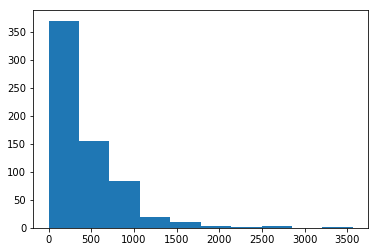

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.hist(total_minutes_by_account_passing.values())

(array([ 272.,   34.,   17.,    9.,    6.,    2.,    1.,    5.,    0.,    2.]),
 array([    0.        ,   176.85227493,   353.70454987,   530.5568248 ,
          707.40909973,   884.26137467,  1061.1136496 ,  1237.96592453,
         1414.81819947,  1591.6704744 ,  1768.52274933]),
 <a list of 10 Patch objects>)

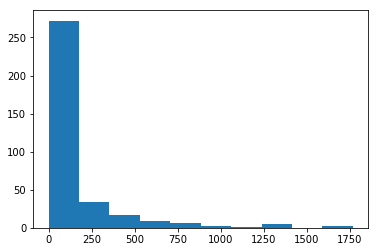

In [41]:
plt.hist(total_minutes_by_account_non_passing.values())

(array([ 516.,   97.,   23.,    4.,    3.,    3.,    0.,    0.,    0.,    1.]),
 array([  0. ,   3.6,   7.2,  10.8,  14.4,  18. ,  21.6,  25.2,  28.8,
         32.4,  36. ]),
 <a list of 10 Patch objects>)

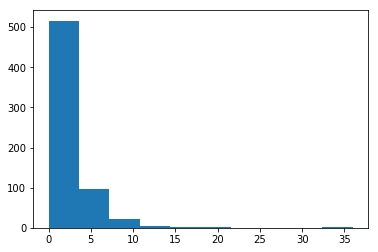

In [42]:
plt.hist(total_lessons_by_account_passing.values())

(array([ 317.,   17.,    6.,    4.,    1.,    1.,    0.,    1.,    0.,    1.]),
 array([  0. ,   2.7,   5.4,   8.1,  10.8,  13.5,  16.2,  18.9,  21.6,
         24.3,  27. ]),
 <a list of 10 Patch objects>)

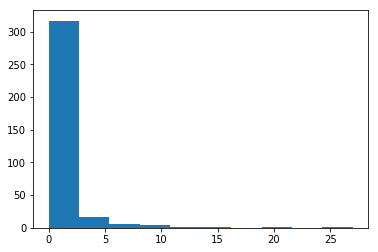

In [43]:
plt.hist(total_lessons_by_account_non_passing.values())

(array([ 87.,  82.,  79.,   0.,  91.,  77.,   0.,  85.,  78.,  68.]),
 array([ 0. ,  0.7,  1.4,  2.1,  2.8,  3.5,  4.2,  4.9,  5.6,  6.3,  7. ]),
 <a list of 10 Patch objects>)

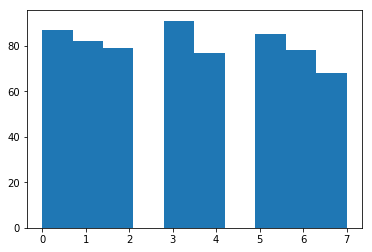

In [44]:
plt.hist(total_days_by_account_passing.values())

(array([ 97.,  90.,  56.,   0.,  41.,  15.,   0.,  24.,  17.,   8.]),
 array([ 0. ,  0.7,  1.4,  2.1,  2.8,  3.5,  4.2,  4.9,  5.6,  6.3,  7. ]),
 <a list of 10 Patch objects>)

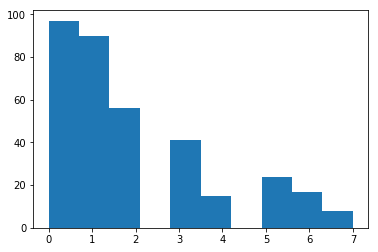

In [45]:
plt.hist(total_days_by_account_non_passing.values())